# Team Harvey Wiley Nutrient System Notebook
In this notebook, we explore how demands for various quantities can be expressed as functions of prices, budgets, and household characteristics. Then, illustrate how these quantities can be translated into nutritional components.

**Usage Note - Updating Notebook**:
- If you make changes locally to your version of the notebook, you will need to manually update the notebook via the following steps
    1. Uncomment the code in the cell below and run it.
    2. Restart the notebook's kernel.
    3. Refresh the page. <br>
    **Warning** - Make sure that the aforementioned code is commented once you successfully updated the notebook.

In [68]:
import pandas as pd
import numpy as np
import cfe.regression as rgsn
import matplotlib.pyplot as plt

In [42]:
%run demand.ipynb

### Load In Data

In [45]:
def load_in_data(country, year_range):
    country = country.lower()
    p = pd.read_csv(f'./data/{country}/food_prices.csv')

    p = p.set_index(['t','m'])
    p.columns.name = 'j'

    p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    p = p.replace(0,np.nan)

    fct = pd.read_csv(f'./data/{country}/fct.csv')

    fct = fct.set_index('j')
    fct.columns.name = 'n'

    fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

    rdi = pd.read_csv(f'./data/{country}/rdi.csv')
    rdi = rdi.set_index('n')
    rdi.columns.name = 'k'

    r = rgsn.read_pickle(f"./estimates/{country}/{year_range.replace('-', '_')}.rgsn")
    return p, fct, rdi, r

In [50]:
country = 'Uganda'
year_range = '2013-14'
p, fct, rdi, r = load_in_data(country, year_range)

In [62]:
def get_pbqs(p, r, desired_percentile):
    '''
    Description
    --------------------------------------------------
    This function gets price references at a desired 
    percentile, budgets & food quantities.
    '''
    pbar = p.xs(year_range, level = 't').mean()
    pbar = pbar[r.beta.index]

    xhat = r.predicted_expenditures()

    xbar = xhat.groupby(['i','t','m']).sum()

    xref = xbar.quantile(desired_percentile / 100)

    qhat = (xhat.unstack('j')/pbar).dropna(how='all')

    qhat = qhat.loc[:, qhat.count() > 0]
    
    return pbar, xhat, xbar, xref, qhat

In [64]:
desired_percentile = 50
pbar, xhat, xbar, xref, qhat = get_pbqs(p, r, desired_percentile)

In [72]:
fct0, c0 = fct.align(qhat.T, axis = 0,join = 'inner')
N = fct0.T@c0

In [74]:
def nutrient_demand(x, p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

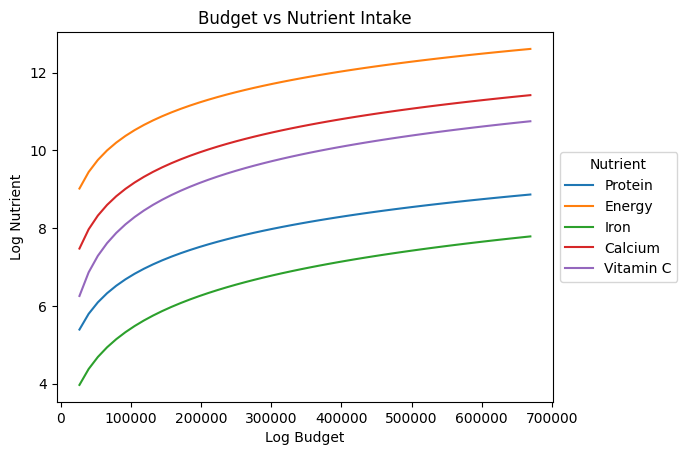

In [119]:
X = np.linspace(xref / 5, xref * 5, 50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('Log Budget')
ax.set_ylabel('Log Nutrient')
ax.set_title('Budget vs Nutrient Intake')
plt.legend(title = 'Nutrient', loc= 'center left', bbox_to_anchor=(1, 0.5));

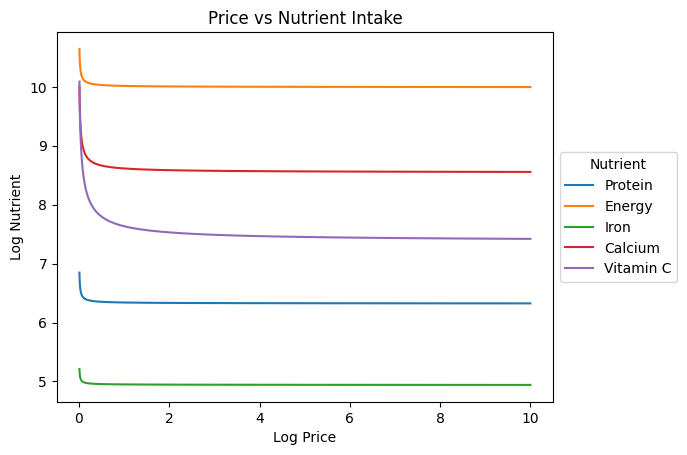

In [117]:
USE_GOOD = 'Oranges'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref / 2, change_price(p0 = pbar[USE_GOOD] * s,
                                                                    p = pbar,
                                                                    j = USE_GOOD)))[UseNutrients] for s in scale}).T


ax = ndf.plot()

ax.set_xlabel('Log Price')
ax.set_ylabel('Log Nutrient')
ax.set_title('Price vs Nutrient Intake')
plt.legend(title = 'Nutrient', loc= 'center left', bbox_to_anchor=(1, 0.5));